The simplex method requires an equational form of linear program representation:
                        Maximize cᵀx subject to Ax=b, x≥0

x is the vector of variables, A is a given m×n matrix, c∈ Rⁿ, b∈ Rᵐ are given vectors, and 0 is the zero vector, in this case with n components. All variables in the equational form have to satisfy the nonnegativity constraints.

Ex 1.: Maximize the value x₁ + x₂ among all vector (x₁, x₂) ∈ R², satisfying the constraints:
  x₁ ≥ 0
  x₂ ≥ 0
  4x₂ - x₁ ≤ 13
  x₂ + 2x₁ ≤ 10

In [14]:
from scipy.spatial import HalfspaceIntersection, ConvexHull
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np


# create a function that will render convex polygon from given inequalities
    ## this function will receive inequalities, point contained in polygon and bounds
def render_inequations(halfspaces, feasible_point, xlim, ylim):
    hs = HalfspaceIntersection(np.array(halfspaces), feasible_point)
    fig = plt.figure()
    ax = fig.add_subplot(111, aspect='equal')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

    x = np.linspace(*xlim, 100)

    for h in halfspaces:
        if h[1]== 0:
            ax.axvline(-h[2]/h[0], color="#2c3e50")
        else:
            ax.plot(x, (-h[2]-h[0]*x)/h[1], color="#2c3e50")
    x, y = zip(*hs.intersections)
    points = list(zip(x, y))
    convex_hull = ConvexHull(points)
    polygon = Polygon([points[v] for v in convex_hull.vertices], color="#34495e")
    ax.add_patch(polygon)
    ax.plot(x, y, 'o', color="#e67e22")

We will improve this function in the next parts since now we can use it only after we draw inequalities manually on a piece of paper. As soon as we learn how to solve linear equations, we will be able to render polygon without providing a feasible point.

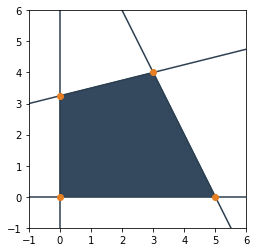

In [15]:
halfspaces = [
    [-1, 0., 0.],    # x₁ ≥ 0
    [0., -1., 0.],   # x₂ ≥ 0
    [-1., 4., -13.], # 4x₂ - x₁ ≤ 13
    [2., 1., -10.]   # x₂ + 2x₁ ≤ 10
]
feasible_point = np.array([0.5, 0.5])
xlim = (-1, 6)
render_inequations(halfspaces, feasible_point, xlim, xlim)

            Transform to equational form

In order to convert the inequality 4x₂ -x₁ ≤ 13 we introduce a new variable x₃, together with the nonnegativity constraint x₃ ≥ 0, and we replace the considered inequality by the equation -x₁ + 4x₂ + x₃ = 13. The additional variable(slack variable) x₃, which won’t appear anywhere else in the transformed linear program, represents the difference between the right-hand side and the left-hand side of the inequality.

We need to do the same with x₂ + 2x₁≤ 10. We introduce a new slack variable x₃, together with the nonnegativity constraint x₄ ≥ 0. As a result, we have this equation 2x₁ + x₂ + x₄ = 10.

The resulting equational form of our linear program looks this way:
Maximize x₁ + x₂ subject to

  -x₁ + 4x₂ + x₃ = 13
  2x₁ +x₂ + x₄ = 10
  x₁ ≥ 0, x₂ ≥ 0, x₃ ≥ 0, x₄ ≥ 0


Geometry
As is derived in linear algebra, the set of all solutions of the system Ax = b is an affine subspace F of the space Rⁿ. Hence the set of all feasible solutions of the linear program is the intersection of F with the nonnegative orthant, which is the set of all points in Rⁿ with all coordinates nonnegative.

In [1]:
import numpy as np
a = [
    [-1, 4, 1, 0],
    [2, 1, 0, 1],
    [0, 0, 1, 0],
    [0, 0, 0, 1]
]
b = [13, 10, 0, 0]
x1, x2, x3, x4 = np.linalg.solve(a, b)
print('x1 =', x1)
print('x2 =', x2)

x1 = 3.0
x2 = 4.0


In [26]:
c = [1, 1, 0, 0, 0]
A = [
    [-1, 1, 1, 0, 0],
    [ 1, 0, 0, 1, 0],
    [ 0, 1, 0, 0, 1]
]
b = [2, 4, 4]

def to_tableau(c, A, b):
    xb = [eq + [x] for eq, x in zip(A, b)]
    z = c + [0]
    return xb + [z]


def can_be_improved(tableau):
    z = tableau[-1]
    return any(x > 0 for x in z[:-1])
import math

def get_pivot_position(tableau):
    z = tableau[-1]
    column = next(i for i, x in enumerate(z[:-1]) if x > 0)
    
    restrictions = []
    for eq in tableau[:-1]:
        el = eq[column]
        restrictions.append(math.inf if el <= 0 else eq[-1] / el)

    row = restrictions.index(min(restrictions))
    return row, column

def pivot_step(tableau, pivot_position):
    new_tableau = [[] for eq in tableau]
    
    i, j = pivot_position
    pivot_value = tableau[i][j]
    new_tableau[i] = np.array(tableau[i]) / pivot_value
    
    for eq_i, eq in enumerate(tableau):
        if eq_i != i:
            multiplier = np.array(new_tableau[i]) * tableau[eq_i][j]
            new_tableau[eq_i] = np.array(tableau[eq_i]) - multiplier
   
    return new_tableau
def is_basic(column):
    return sum(column) == 1 and len([c for c in column if c == 0]) == len(column) - 1

def get_solution(tableau):
    columns = np.array(tableau).T
    solutions = []
    for column in columns:
        solution = 0
        if is_basic(column):
            one_index = column.tolist().index(1)
            solution = columns[-1][one_index]
        solutions.append(solution)
        
    return solutions
def simplex(c, A, b):
    tableau = to_tableau(c, A, b)

    while can_be_improved(tableau):
        pivot_position = get_pivot_position(tableau)
        tableau = pivot_step(tableau, pivot_position)

    return get_solution(tableau)
solution = simplex(c, A, b)
print('solution: ', solution)

solution:  [4.0, 4.0, 2.0, 0, 0, 0]
